# **TikTok Project**
**Course 5 - The nuts and bolts of machine learning**

# **Classifying videos using machine learning**


**The purpose** of this model is to mitigate misinformation in videos on the TikTok platform.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps



# **Classify videos using machine learning**

# **PACE stages**


## **Pace: Plan**

**Exemplar responses:**

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data has a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.

**Select an evaluation metric**

To determine which evaluation metric might be best, we have to consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim



**What are the ethical implications of building the model?**
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.


**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)




In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

## **PACE: Analyze**


In [4]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [5]:
# Get number of rows and columns
data.shape

(19382, 12)

In [6]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [7]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [8]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [9]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [10]:
# Check for duplicates
data.duplicated().sum()

0

here are no duplicate observations in the data.

Check for and handle outliers

Tree-based models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

In [11]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

## **PACE: Construct**

### **Feature engineering**


Extract the length (character count) of each `video_transcription_text` and add this to the dataframe as a new column called `text_length` so that it can be used as a feature in the model.

In [12]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average `text_length` for claims and opinions.



In [13]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


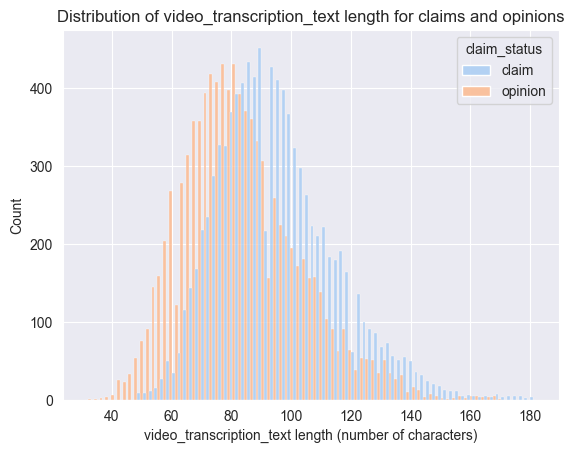

In [14]:
# Visualize the distribution of `text_length` for claims and opinions

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

Encode target and catgorical variables.

In [16]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

C:\Users\AL\AppData\Local\Temp\ipykernel_13720\154164835.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Split the data**

Assign target variable.

In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [17]:
# Isolate target variable
y = X['claim_status']

In [25]:
# Isolate features
X = X.drop(['claim_status','video_transcription_text'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [26]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [27]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [28]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

### **Build models**

### **Build a random forest model**


Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [29]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [30]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 3min 15s
Wall time: 3min 19s


,estimator,RandomForestC...andom_state=0)
,param_grid,"{'max_depth': [5, 7, ...], 'max_features': [0.3, 0.6], 'max_samples': [0.7], 'min_samples_leaf': [1, 2], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,75


In [31]:
# Examine best recall score
rf_cv.best_score_

0.9908534395531852

In [32]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [33]:
# Access the GridSearch results and convert it to a pandas df
rf_results_df = pd.DataFrame(rf_cv.cv_results_)

# Examine the GridSearch results df at column `mean_test_precision` in the best index
rf_results_df['mean_test_precision'][rf_cv.best_index_]

0.9994785483051682

This model performs exceptionally well, with an average recall score of 0.9995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [34]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [35]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 1min 37s
Wall time: 12.8 s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, ...], 'min_child_weight': [3, 5], 'n_estimators': [300, 500]}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [36]:
xgb_cv.best_score_

0.9898176171763818

In [37]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

In [38]:
# Access the GridSearch results and convert it to a pandas df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)

# Examine the GridSearch results df at column `mean_test_precision` in the best index
xgb_results_df['mean_test_precision'][xgb_cv.best_index_]

0.9989540885869099

This model also performs exceptionally well. Although both its precision and recall scores are very slightly lower than the random forest model's.

## **PACE: Execute**

### **Evaluate models**

Evaluate models against validation data.


#### **Random forest**

In [39]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val)

In [40]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [41]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

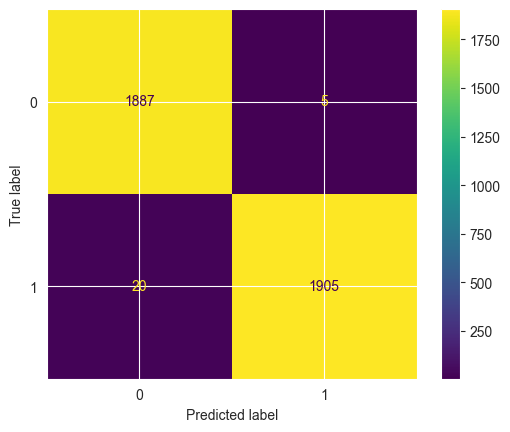

In [42]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model produces five false negatives and five false positives.

In [43]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The classification report above shows that the random forest model scores were perfect, but we know they weren't quite perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

In [44]:
# Use the best estimator to predict on the validation data
y_pred = xgb_cv.best_estimator_.predict(X_val)

In [45]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

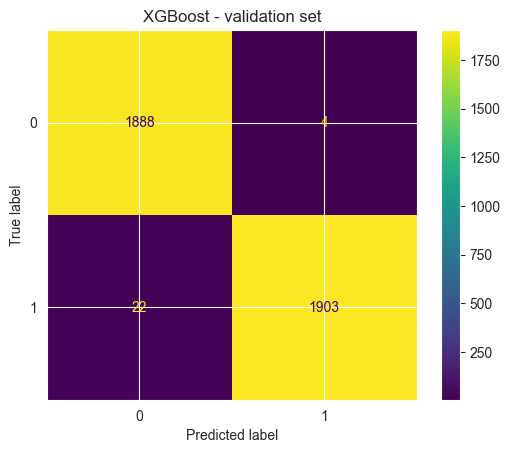

In [46]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [47]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better scores, and is therefore the champion model.

### **Use champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [48]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test)

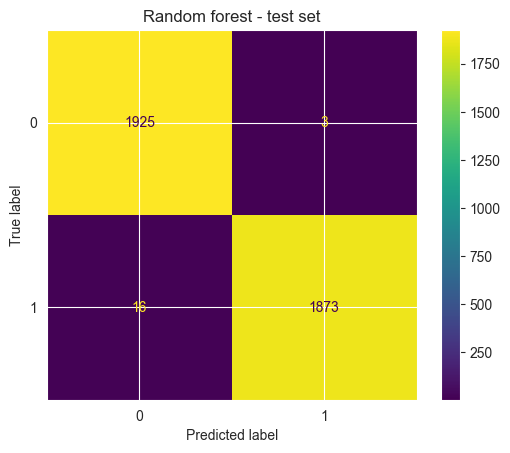

In [49]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**



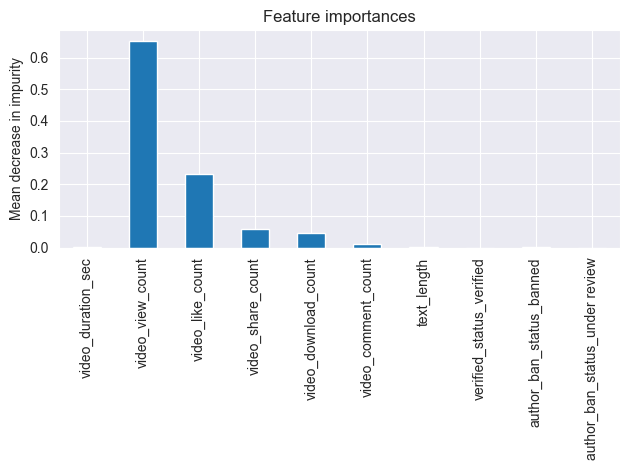

In [50]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

### **Conclusion**


1. *Would i recommend using this model?*
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2. *What was ;Y model doing?*
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3. *Are there new features that i can engineer that might improve model performance?*
Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4. *What features would you want to have that would likely improve the performance of your model?*
The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.